#Sets up a MetData File for the L&PTrial

##Import components

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

##Import met data from datalogger csv file

In [2]:
LandPMetData=pd.read_csv('./DataFiles/LandPCanopyTemperatureAndHeatFluxData.csv.gz', #specify file path for data to read in
                         compression='gzip', #tell the function it is a compressed file
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [1,2], #leave out rows 2 and 3 which have redundant information
                         usecols=[0,4,5,6,7,8,9,10,11], #Specify the columns that have useful met data in them
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')#  #Tell it what the error values look like

##Have a look at the dataframe structure

In [3]:
LandPMetData[0:7]

,AirTC_Avg,RH_Max,daylight,SlrkW_Avg,SlrMJ_Tot,Rain_mm_Tot,WS_ms_Avg,LeafWet_kohms_Avg
TIMESTAMP,,,,,,,,
2012-02-20 15:10:00,27.49,44.19,daylight,0.869,0.260744,0,0.000,7999.0
2012-02-20 15:15:00,27.39,44.63,daylight,0.860,0.258088,0,1.212,7999.0
2012-02-20 15:20:00,27.29,44.43,daylight,0.852,0.255551,0,1.332,7999.0
2012-02-20 15:25:00,27.08,43.92,daylight,0.844,0.253255,0,1.457,7999.0
2012-02-20 15:30:00,26.61,45.75,daylight,0.834,0.250234,0,1.628,7999.0
2012-02-20 15:35:00,26.47,45.89,daylight,0.827,0.248180,0,1.383,7999.0
2012-02-20 15:40:00,26.27,45.68,daylight,0.817,0.245157,0,1.416,7999.0


In [4]:
LandPMetData.axes  #Check to see what our row and column indexes look like

[DatetimeIndex(['2012-02-20 15:10:00', '2012-02-20 15:15:00',
                '2012-02-20 15:20:00', '2012-02-20 15:25:00',
                '2012-02-20 15:30:00', '2012-02-20 15:35:00',
                '2012-02-20 15:40:00', '2012-02-20 15:45:00',
                '2012-02-20 15:50:00', '2012-02-20 15:55:00',
                ...
                '2014-05-09 07:15:00', '2014-05-09 07:30:00',
                '2014-05-09 07:45:00', '2014-05-09 08:00:00',
                '2014-05-09 08:15:00', '2014-05-09 08:30:00',
                '2014-05-09 08:45:00', '2014-05-09 09:00:00',
                '2014-05-09 09:15:00', '2014-05-09 09:30:00'],
               dtype='datetime64[ns]', name=u'TIMESTAMP', length=132169, freq=None),
 Index([u'AirTC_Avg', u'RH_Max', u'daylight', u'SlrkW_Avg', u'SlrMJ_Tot',
        u'Rain_mm_Tot', u'WS_ms_Avg', u'LeafWet_kohms_Avg'],
       dtype='object')]

In [5]:
LandPMetData.dtypes

AirTC_Avg            float64
RH_Max               float64
daylight              object
SlrkW_Avg            float64
SlrMJ_Tot            float64
Rain_mm_Tot            int64
WS_ms_Avg            float64
LeafWet_kohms_Avg    float64
dtype: object

In [6]:
LandPMetData.describe()

,AirTC_Avg,RH_Max,SlrkW_Avg,SlrMJ_Tot,Rain_mm_Tot,WS_ms_Avg,LeafWet_kohms_Avg
count,132169.000000,132169.000000,132166.000000,132166.000000,132169.000000,132169.000000,1.169990e+05
mean,10.714837,79.451044,0.148768,0.898197,0.012787,1.306047,inf
std,5.968348,17.400512,0.244398,2.473425,0.127969,1.418573,NaN
min,-7.650000,13.810000,0.000000,0.000000,0.000000,0.000000,-7.999000e+03
25%,6.701000,67.120000,0.000000,0.000000,0.000000,0.370000,6.208500e+01
50%,10.140000,84.800000,0.002000,0.004970,0.000000,0.888000,7.999000e+03
75%,14.200000,94.400000,0.215000,0.142446,0.000000,1.770000,7.999000e+03
max,36.310000,100.000000,1.497000,16.397520,13.000000,10.980000,inf


#Draw some graphs to make sure everything looks OK

##Full data sets first

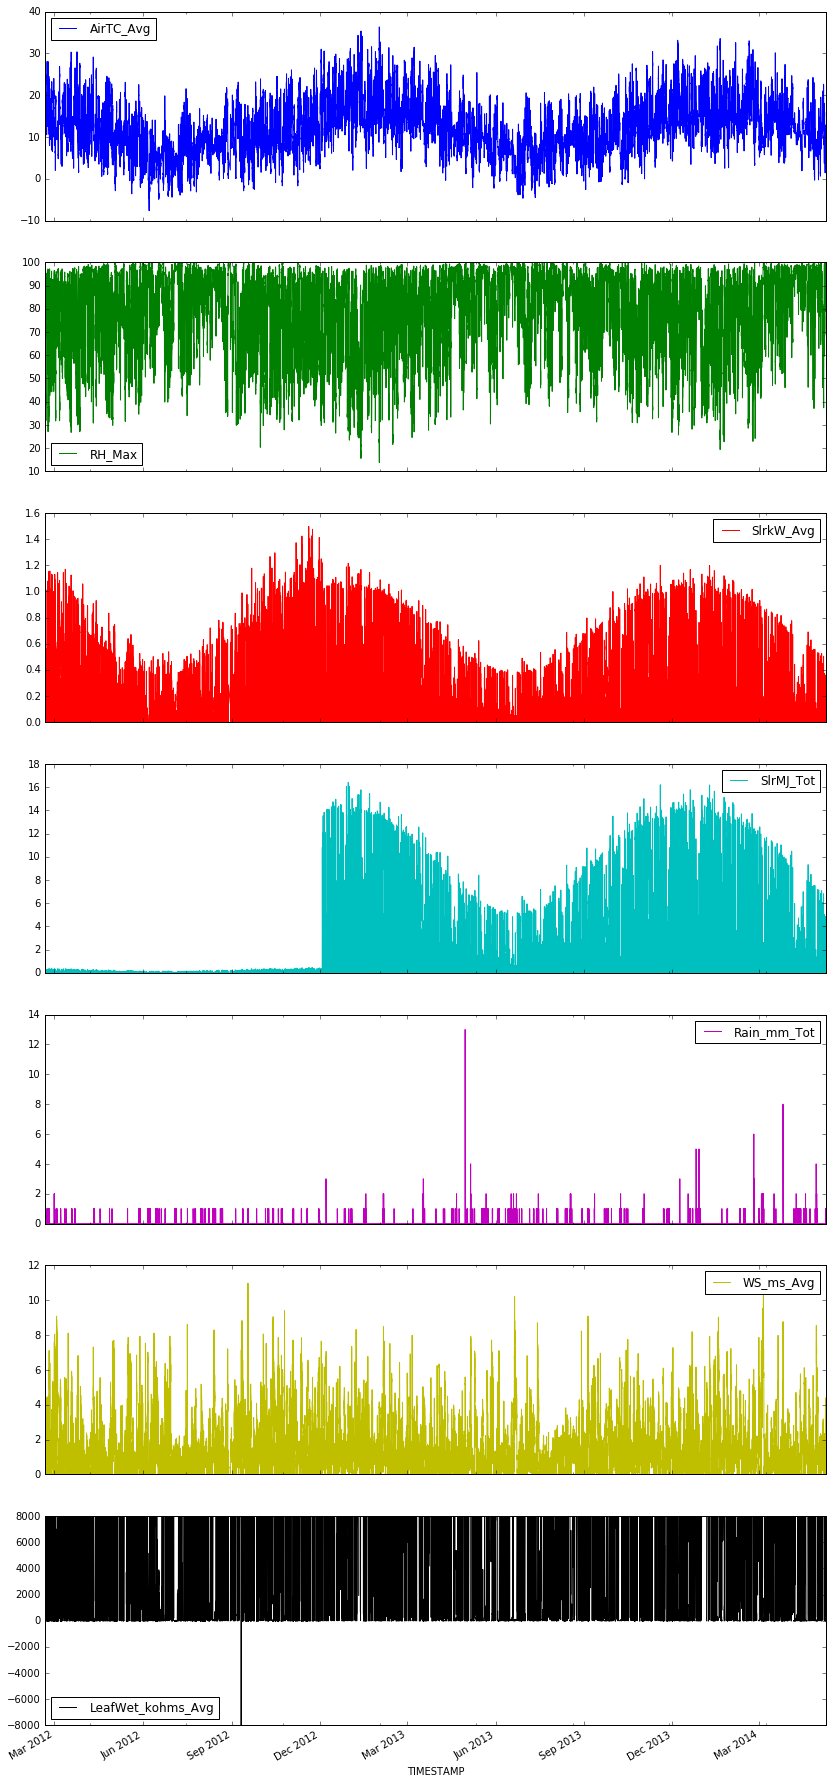

In [7]:
%matplotlib inline
LandPMetData.plot(legend=True, figsize=(14, 34), subplots = True);

Note the change in scale in the solar radiation data in December.  This is because we changed the frequence of recording but forgot to change the time value being used to calculate radiation values.  Need to divide by 30 to correct

In [8]:
LandPMetData.ix['2012-12-03':,'SlrMJ_Tot'] = LandPMetData.ix['2012-12-03':,'SlrMJ_Tot']/30

##Resample to give daily summary values

In [9]:
DailyMinTemp = LandPMetData['AirTC_Avg'].resample('D', how='min')
#DailyMinTemp.name = 'MinT'
DailyMaxTemp = LandPMetData['AirTC_Avg'].resample('D', how='max')
DailyMeanTemp = (DailyMaxTemp + DailyMinTemp )/2
AccumThermalTime = DailyMeanTemp.cumsum()
DailyRainfall = LandPMetData['Rain_mm_Tot'].resample('D', how='sum')
DailyWindSpeed = LandPMetData['WS_ms_Avg'].resample('D', how='mean')
DailySolarRadiation = LandPMetData['SlrMJ_Tot'].resample('D', how='sum')
DailySolarRadiation['2012-12-03':] *= 2  #multiply solar radiation by 2 after Dec 2012 to account for wrong time correction in datalogger program

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
  if __name__ == '__main__':
C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  app.launch_new_instance()
C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


In [10]:
dailymetdata=pd.concat([DailyMinTemp,DailyMaxTemp,DailyMeanTemp,AccumThermalTime,DailyRainfall,
           DailyWindSpeed,DailySolarRadiation ],axis=1)
dailymetdata.head()

,AirTC_Avg,AirTC_Avg,AirTC_Avg,AirTC_Avg,Rain_mm_Tot,WS_ms_Avg,SlrMJ_Tot
TIMESTAMP,,,,,,,
2012-02-20,12.39,27.49,19.940,19.940,0.0,0.858387,8.566271
2012-02-21,12.75,28.04,20.395,40.335,1.0,0.424594,11.743075
2012-02-22,10.52,18.98,14.750,55.085,4.0,1.356194,11.115608
2012-02-23,12.49,28.08,20.285,75.370,7.0,1.479205,19.417667
2012-02-24,10.52,24.49,17.505,92.875,14.0,1.616972,12.007645


###Apply unique column names for daily met data

In [11]:
dailymetdata.columns = ['AirTMin', 'AirTMax', 'AirTMean', 'AccumTT', 'Rain_mm_Tot', 'WS_ms_Avg', 'SlrMJ_Tot']

In [12]:
dailymetdata.columns

Index([u'AirTMin', u'AirTMax', u'AirTMean', u'AccumTT', u'Rain_mm_Tot',
       u'WS_ms_Avg', u'SlrMJ_Tot'],
      dtype='object')

-------------------

### Make Some Plots

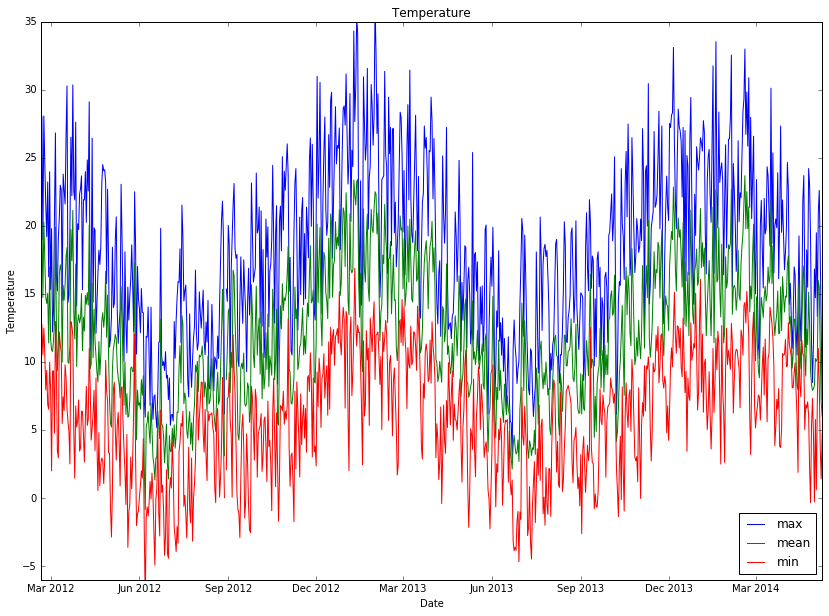

In [13]:
plt.figure(figsize=(14, 10));
plt.title('Temperature');
plt.plot(DailyRainfall.index,DailyMaxTemp, label='max');
plt.plot(DailyRainfall.index,DailyMeanTemp, label='mean');
plt.plot(DailyRainfall.index,DailyMinTemp, label='min');
plt.ylim(-6,35);
plt.xlabel('Date');
plt.ylabel('Temperature');
plt.legend(loc='best');

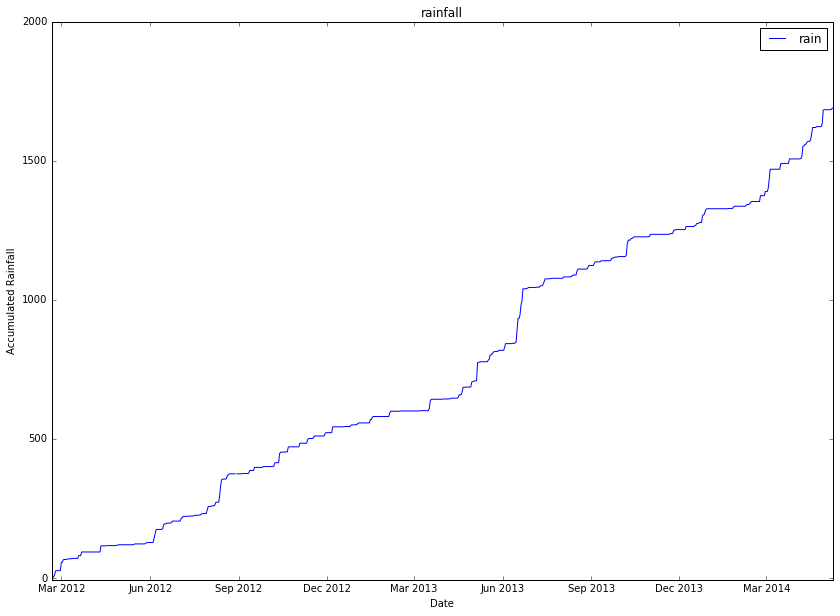

In [14]:
plt.figure(figsize=(14, 10));
plt.title('rainfall');
plt.plot(DailyRainfall.index,DailyRainfall.cumsum(), label='rain');
plt.ylim(-6,2000);
plt.xlabel('Date');
plt.ylabel('Accumulated Rainfall');
plt.legend(loc='best');

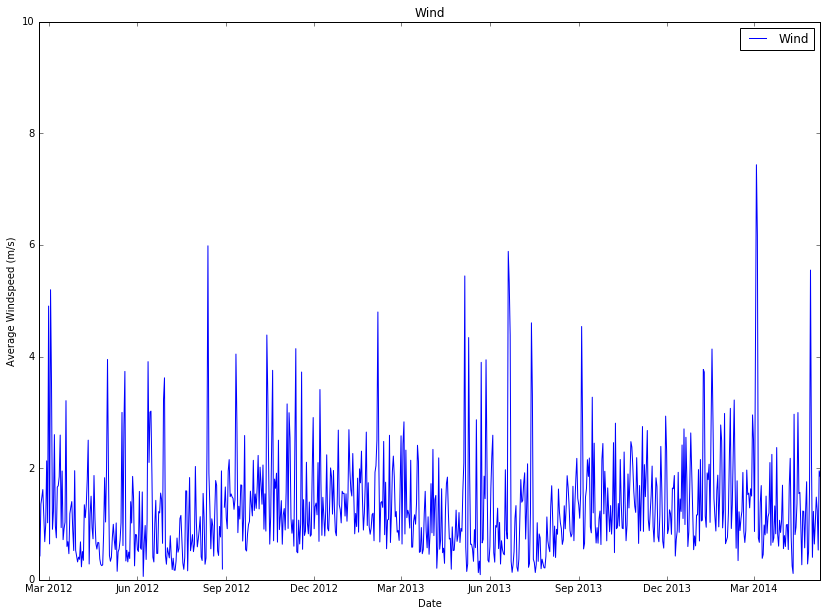

In [15]:
plt.figure(figsize=(14, 10));
plt.title('Wind');
plt.plot(DailyWindSpeed.index,DailyWindSpeed, label='Wind');
plt.ylim(0,10);
plt.xlabel('Date');
plt.ylabel('Average Windspeed (m/s)');
plt.legend(loc='best');

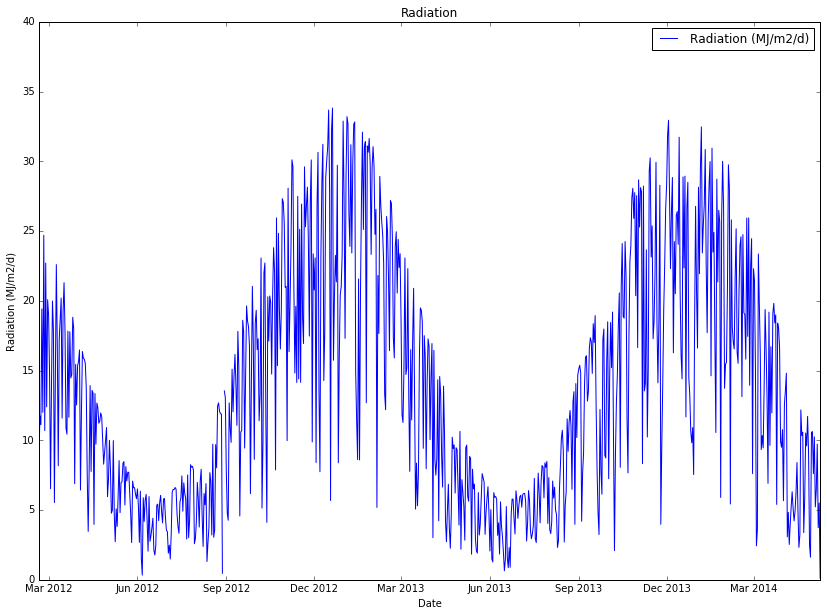

In [16]:
plt.figure(figsize=(14, 10));
plt.title('Radiation');
plt.plot(DailySolarRadiation.index,DailySolarRadiation, label='Radiation (MJ/m2/d)');
plt.ylim(0,40);
plt.xlabel('Date');
plt.ylabel('Radiation (MJ/m2/d)');
plt.legend(loc='best');

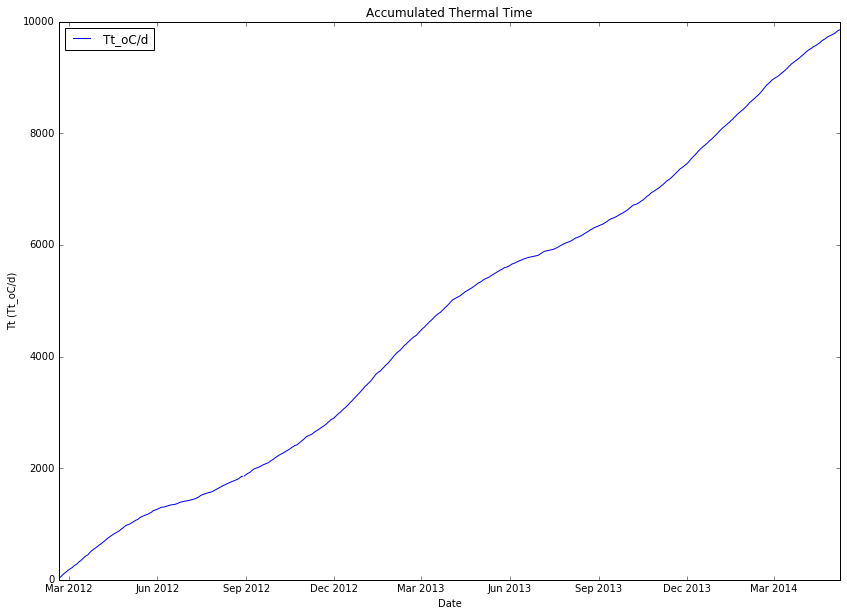

In [17]:
plt.figure(figsize=(14, 10));
plt.title('Accumulated Thermal Time');
plt.plot(AccumThermalTime.index,AccumThermalTime, label='Tt_oC/d');
plt.ylim(0,10000);
plt.xlabel('Date');
plt.ylabel('Tt (Tt_oC/d)');
plt.legend(loc='best');

##Bring in Data from Ablock met station for checking and gap filling

In [18]:
ABlockMetData=pd.read_csv('./DataFiles/AblockWeather.csv', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         index_col = 0) #Use the first column, which is Date, as an index
                         

In [19]:
ABlockMetData.index.name

'TIMESTAMP'

In [20]:
ABlockMetData['9/1/2011':'9/6/2011']

,mint,meant,maxt,radn,rain,wind,vp
TIMESTAMP,,,,,,,
2011-09-01,3.4,7.65,11.30,11.30,2.4,3.50,8.86
2011-09-02,-0.7,5.25,15.34,15.34,6.5,2.65,7.81
2011-09-03,-2.0,7.05,14.63,14.63,0.0,1.60,6.23
2011-09-04,0.5,7.85,13.27,13.27,0.0,1.84,8.82
2011-09-05,3.9,9.60,14.61,14.61,0.0,3.95,8.52
2011-09-06,1.6,6.40,10.89,10.89,0.0,2.53,9.62


##Join met data from L&P with Ablock met data so we can do some comparative graphs and check data

In [21]:
MetDataForComparison = pd.concat([ABlockMetData, dailymetdata], axis = 1)

In [22]:
MetDataForComparison['6/1/2013':'6/6/2013']

,mint,meant,maxt,radn,rain,wind,vp,AirTMin,AirTMax,AirTMean,AccumTT,Rain_mm_Tot,WS_ms_Avg,SlrMJ_Tot
TIMESTAMP,,,,,,,,,,,,,,
2013-06-01,3.7,10.7,2.0,2.0,0.0,3.6,10.2,3.299,15.570,9.4345,5632.139,0.0,0.594354,2.064943
2013-06-02,11.3,16.9,5.1,5.1,0.0,6.3,9.7,9.780,19.910,14.8450,5646.984,0.0,1.638250,5.038453
2013-06-03,6.4,9.2,1.5,1.5,9.1,4.5,10.7,5.714,15.880,10.7970,5657.781,10.0,2.215667,1.501425
2013-06-04,4.0,7.1,1.3,1.3,13.7,4.9,9.5,4.229,7.225,5.7270,5663.508,14.0,2.591229,1.284146
2013-06-05,0.2,4.6,6.7,6.7,0.4,1.3,7.3,-0.640,9.500,4.4300,5667.938,0.0,0.486177,6.248605
2013-06-06,3.3,7.3,5.8,5.8,0.0,2.1,9.1,2.520,13.760,8.1400,5676.078,0.0,0.316229,5.916399


In [23]:
MetDataForComparison.axes

[DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
                '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
                '2011-01-09', '2011-01-10',
                ...
                '2014-04-30', '2014-05-01', '2014-05-02', '2014-05-03',
                '2014-05-04', '2014-05-05', '2014-05-06', '2014-05-07',
                '2014-05-08', '2014-05-09'],
               dtype='datetime64[ns]', name=u'TIMESTAMP', length=1225, freq='D'),
 Index([u'mint', u'meant', u'maxt', u'radn', u'rain', u'wind', u'vp',
        u'AirTMin', u'AirTMax', u'AirTMean', u'AccumTT', u'Rain_mm_Tot',
        u'WS_ms_Avg', u'SlrMJ_Tot'],
       dtype='object')]

##Draw some graphs to compare Ablock and L&P data

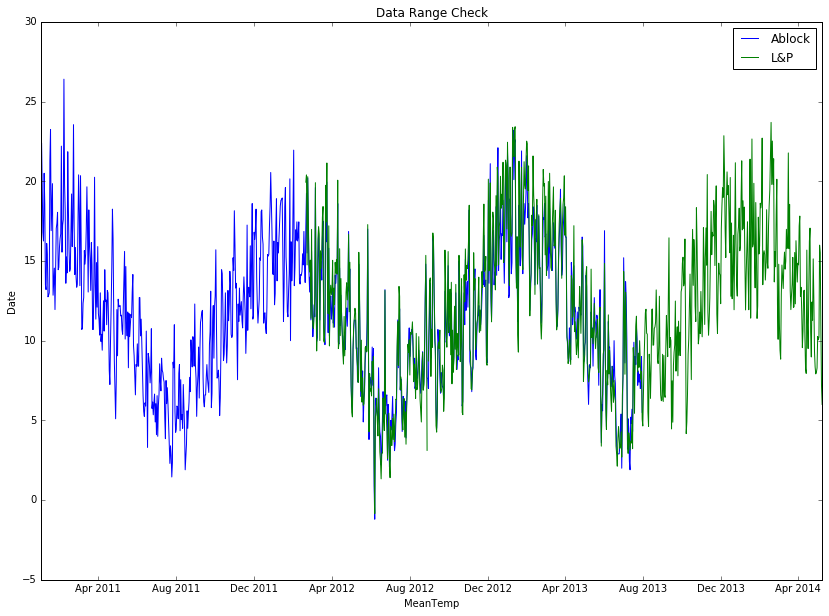

In [24]:
plt.figure(figsize=(14, 10));
plt.title('Data Range Check');
plt.plot(MetDataForComparison.index,MetDataForComparison['meant'], label='Ablock');
plt.plot(MetDataForComparison.index,MetDataForComparison['AirTMean'], label='L&P');
plt.xlabel('MeanTemp');
plt.ylabel('Date');
plt.legend(loc='best');

In [25]:
ModTemp = sm.regression.linear_model.OLS(MetDataForComparison['AirTMean'],  # Y variable
                                        sm.add_constant(MetDataForComparison['meant']), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
RegTemp = ModTemp.fit();  # fit models parameters
print RegTemp.summary()

                            OLS Regression Results                            
Dep. Variable:               AirTMean   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.300e+04
Date:                Fri, 16 Jun 2017   Prob (F-statistic):               0.00
Time:                        09:24:20   Log-Likelihood:                -803.38
No. Observations:                 527   AIC:                             1611.
Df Residuals:                     525   BIC:                             1619.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.7324      0.132     -5.563      0.0

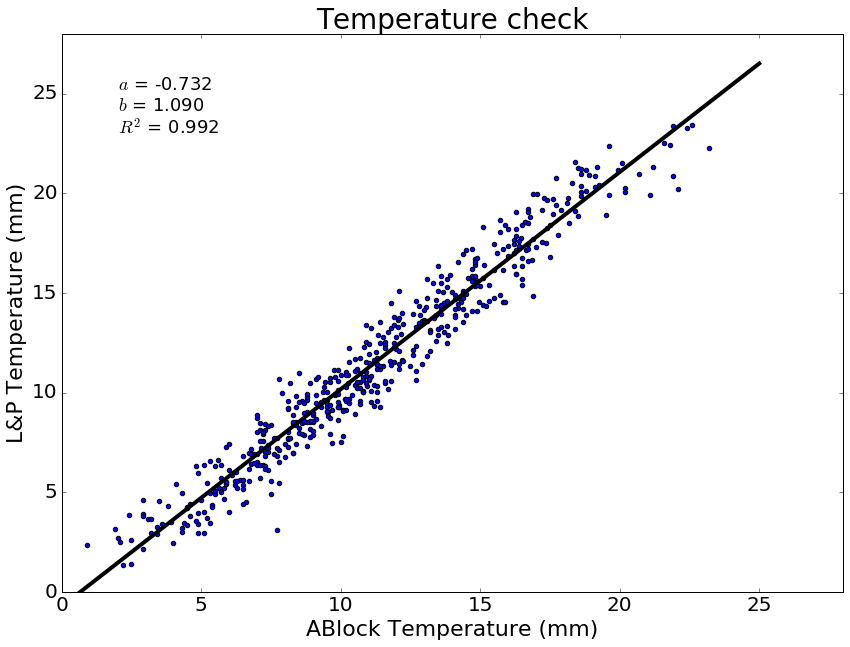

In [26]:
plt.figure(figsize=(14, 10));
plt.title('Temperature check', fontsize=28);
plt.scatter(MetDataForComparison['meant'], MetDataForComparison['AirTMean'], label='Tt_oC/d');
plt.ylim(0,28);
plt.xlim(0,28);
plt.xlabel('ABlock Temperature (mm)', fontsize=22);
plt.ylabel('L&P Temperature (mm)', fontsize=22);
plt.tick_params(labelsize=20)
xmin = 0
xmax = 25
Regres = RegTemp
radn_x = [xmin,xmax];
radn_y_fits = [Regres.params.const, Regres.params.const + xmax * Regres.params.meant];
plt.plot(radn_x, radn_y_fits, c='k', lw=4);
plt.text(2,23,  # x,y location of text box
         '$a$ = %.3f\n$b$ = %.3f\n$R^2$ = %.3f'%(Regres.params.const, Regres.params.meant, Regres.rsquared)  #text box contents
         , fontsize=18)

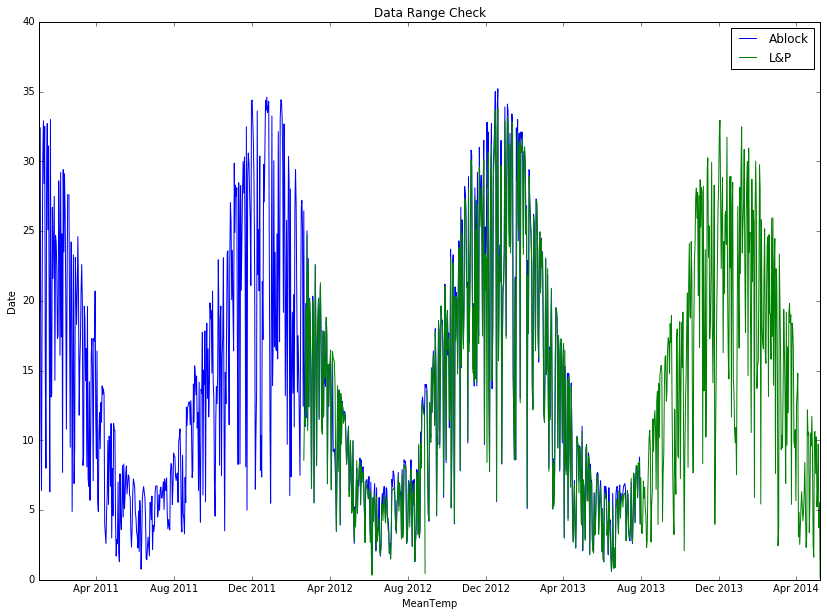

In [27]:
plt.figure(figsize=(14, 10));
plt.title('Data Range Check');
plt.plot(MetDataForComparison.index,MetDataForComparison['radn'], label='Ablock');
plt.plot(MetDataForComparison.index,MetDataForComparison['SlrMJ_Tot'], label='L&P');
plt.xlabel('MeanTemp');
plt.ylabel('Date');
plt.legend(loc='best');


In [28]:
ModRad = sm.regression.linear_model.OLS(MetDataForComparison['SlrMJ_Tot'],
                                        sm.add_constant(MetDataForComparison['radn']),
                                        missing='drop',
                                        hasconst=False)
RegRad = ModRad.fit();
RegRad.params

const    0.259172
radn     0.953014
dtype: float64

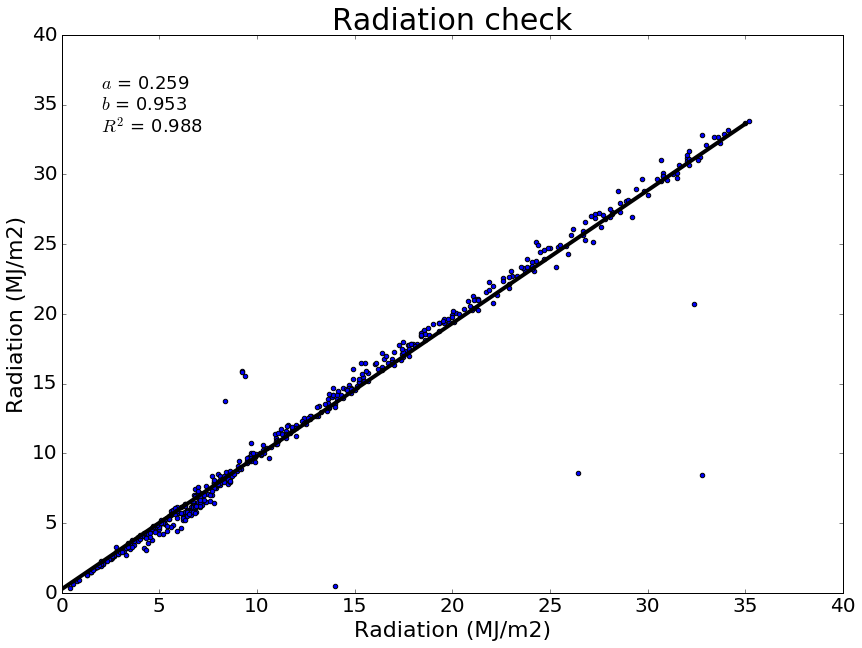

In [29]:
plt.figure(figsize=(14, 10));
plt.title('Radiation check', fontsize=30);
plt.scatter(MetDataForComparison['radn'], MetDataForComparison['SlrMJ_Tot']);
plt.ylim(0,40);
plt.xlim(0,40);
plt.xlabel('Radiation (MJ/m2)', fontsize=22);
plt.ylabel('Radiation (MJ/m2)', fontsize=22);
plt.tick_params(labelsize=20)
xmin = 0
xmax = 35
Regres = RegRad
radn_x = [xmin,xmax];
radn_y_fits = [Regres.params.const, Regres.params.const + xmax * Regres.params.radn];
plt.plot(radn_x, radn_y_fits, c='k', lw=4);
plt.text(2,33,  # x,y location of text box
         '$a$ = %.3f\n$b$ = %.3f\n$R^2$ = %.3f'%(Regres.params.const, Regres.params.radn, Regres.rsquared)  #text box contents
         , fontsize=18)

In [30]:
ModRain = sm.regression.linear_model.OLS(MetDataForComparison['Rain_mm_Tot'],
                                        sm.add_constant(MetDataForComparison['rain']),
                                        missing='drop',
                                        hasconst=False)
RegRain = ModRain.fit();
RegRain.params

const   -0.008402
rain     1.062975
dtype: float64

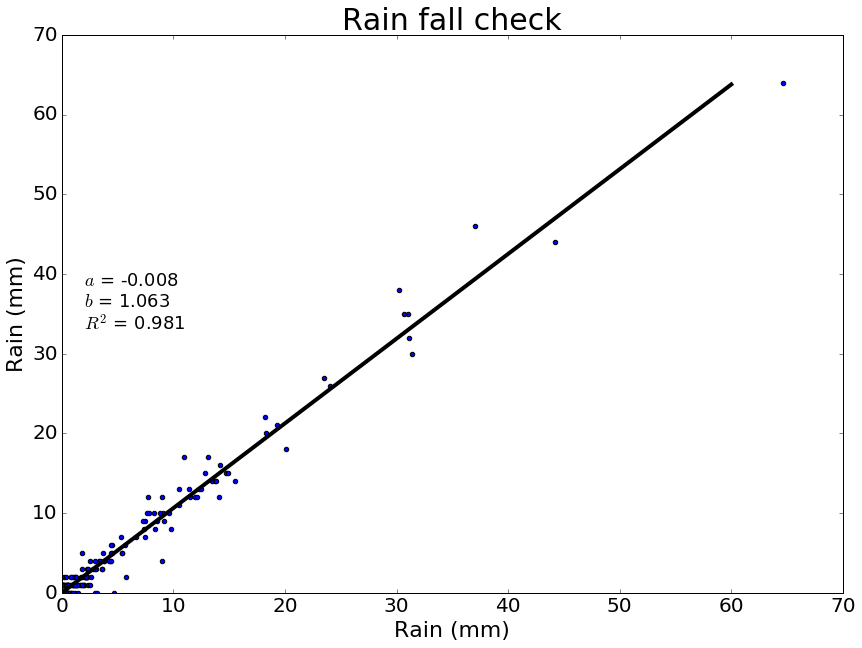

In [31]:
plt.figure(figsize=(14, 10));
plt.title('Rain fall check', fontsize=30);
plt.scatter(MetDataForComparison['rain'], MetDataForComparison['Rain_mm_Tot'], label='Tt_oC/d');
plt.ylim(0,70);
plt.xlim(0,70);
plt.xlabel('Rain (mm)', fontsize=22);
plt.ylabel('Rain (mm)', fontsize=22);
plt.tick_params(labelsize=20)
xmin = 0
xmax = 60
Regres = RegRain
radn_x = [xmin,xmax];
radn_y_fits = [Regres.params.const, Regres.params.const + xmax * Regres.params.rain];
plt.plot(radn_x, radn_y_fits, c='k', lw=4);
plt.text(2,33,  # x,y location of text box
         '$a$ = %.3f\n$b$ = %.3f\n$R^2$ = %.3f'%(Regres.params.const, Regres.params.rain, Regres.rsquared)  #text box contents
         , fontsize=18)

#Now make a full met data set with the gaps from L&P plugged with Ablock data and appropriate corrections applied and export to pickle for use in other analysis

In [32]:
MetDataForComparison.axes

[DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
                '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
                '2011-01-09', '2011-01-10',
                ...
                '2014-04-30', '2014-05-01', '2014-05-02', '2014-05-03',
                '2014-05-04', '2014-05-05', '2014-05-06', '2014-05-07',
                '2014-05-08', '2014-05-09'],
               dtype='datetime64[ns]', name=u'TIMESTAMP', length=1225, freq='D'),
 Index([u'mint', u'meant', u'maxt', u'radn', u'rain', u'wind', u'vp',
        u'AirTMin', u'AirTMax', u'AirTMean', u'AccumTT', u'Rain_mm_Tot',
        u'WS_ms_Avg', u'SlrMJ_Tot'],
       dtype='object')]

In [33]:
MetDataForComparison['AirTMin'] = MetDataForComparison['AirTMin'].fillna(RegTemp.params.const + MetDataForComparison['mint'] * RegTemp.params.meant)
MetDataForComparison['AirTMax'] = MetDataForComparison['AirTMax'].fillna(RegTemp.params.const + MetDataForComparison['maxt'] * RegTemp.params.meant)
MetDataForComparison['AirTMean'] = MetDataForComparison['AirTMean'].fillna(RegTemp.params.const + MetDataForComparison['meant'] * RegTemp.params.meant)
MetDataForComparison['SlrMJ_Tot'] = MetDataForComparison['SlrMJ_Tot'].fillna(MetDataForComparison['radn'])
MetDataForComparison['Rain_mm_Tot'] = MetDataForComparison['Rain_mm_Tot'].fillna(MetDataForComparison['rain'])
MetDataForComparison['WS_ms_Avg'] = MetDataForComparison['WS_ms_Avg'].fillna(MetDataForComparison['wind'])
MetDataForComparison['AccumTT']= MetDataForComparison['AirTMean'].cumsum()

In [43]:
MetDataForComparison.ix['2011-10-01':'2011-11-01',MetDataForComparison.columns.isin(['rain','Rain_mm_Tot'])]

,rain,Rain_mm_Tot
TIMESTAMP,,
2011-10-01,0.0,0.0
2011-10-02,0.0,0.0
2011-10-03,5.0,5.0
2011-10-04,22.7,22.7
2011-10-05,0.2,0.2
2011-10-06,0.0,0.0
2011-10-07,0.0,0.0
2011-10-08,4.2,4.2
2011-10-09,0.0,0.0


In [35]:
MetDataForComparison.ix[:,7:].to_pickle('.\DataFrames\DailyMetData.pkl')

In [36]:
HourlyMetData=LandPMetData.ix[:,['AirTC_Avg', 'RH_Max', 'daylight','SlrMJ_Tot', u'Rain_mm_Tot', 'WS_ms_Avg']]

In [37]:
HourlyMetData.columns = ['AirT', 'RH', 'dailylight', 'Radn', 'Rain_mm_Tot', 'WS_ms_Avg']

In [38]:
HourlyMetData.to_pickle('.\DataFrames\HourlyMetData.pkl')

#### Send to a private Gist

In [39]:
#!gist -p -d "Setting up MetData Frame for Export" SetupMetDataFrame.ipynb

In [40]:
!gist -u https://gist.github.com/73d9d60efe19e2b5e094 SetupMetDataFrame.ipynb

'gist' is not recognized as an internal or external command,
operable program or batch file.


### Export Daily Data to csv format

- need to look at other options like JSON, databases and pickle
- see http://pandas.pydata.org/pandas-docs/stable/io.html#io-json-writercsv

In [41]:
dailymetdata.to_csv(".\DataFrames\dailymetdata.csv")